# Exam, MHPC 2019-2020

In [19]:
import scipy
import sympy as sym
import numpy as np
from scipy.interpolate import *
from scipy.integrate import *
from matplotlib.animation import FuncAnimation
import matplotlib.pyplot as plt

# STEP 1

Write a finite element solver, to solve one step of the problem above, given the solution at the previous time step, using the same techniques used in notebook number 9.

In particular:

STEP 1.1

Write a function that takes in input a vector representing $\eta$, an returns a vector containing $f'(\eta)$. Call this function F.

In [20]:
def f(eta):
    return eta * eta * (eta - 1)**2 

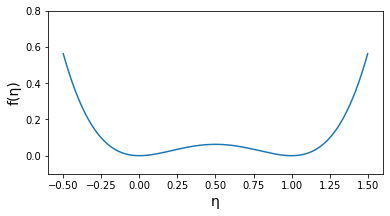

In [21]:
plt.figure(figsize = (6,3))
_ = plt.plot(np.linspace(-0.5,1.5,1025), f(np.linspace(-0.5,1.5, 1025)))
_ = plt.xlabel("\u03B7", fontsize = 14)
_ = plt.ylabel("f(\u03B7)", fontsize = 14)
_ = plt.ylim((-0.1, 0.8))

The derivative of the double well potential function:

In [22]:
def F(eta):
    return 2.*eta*(eta - 1)**2 + 2.*(eta - 1)*eta**2

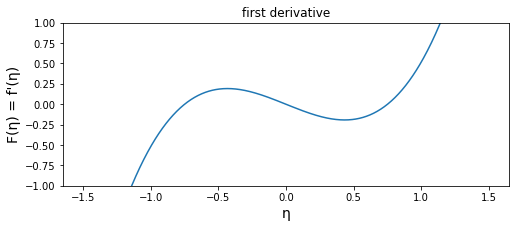

In [23]:
plt.figure(figsize = (8,3))
_ = plt.plot(np.linspace(-1.5,1.5,1025), F(np.linspace(-0.5,1.5,1025)))
_ = plt.xlabel("\u03B7", fontsize = 14)
_ = plt.ylabel("F(\u03B7) = f'(\u03B7)", fontsize = 14)
_ = plt.title("first derivative")
_ = plt.ylim((-1, 1))

STEP 1.2

Write a function that takes in input a vector of support points of dimension ndofs and the degree degree of the polynomial basis, and returns a list of basis functions (piecewise polynomial objects of type PPoly) of dimension ndofs, representing the interpolatory spline basis of degree degree

In [48]:
def basis_func(ndofs, degree):
    basis = []
    
    for i in range(len(ndofs)):
        c = ndofs*0 # array of dim M
        c[i] = 1 # at each step of the cycle i create an array wich take 1 in poi i*1/M
        bi = PPoly.from_spline(splrep(ndofs, c, k = degree)) # create a polinomy of degree =1
        basis.append(bi)
    
    return basis

In [49]:
N = 1025
M = 14
x = np.linspace( -0.5, 1.5 , N) # N punti in [0,1]
q = np.linspace(-0.5, 1.5, M) # M punti in [0,1]
yq = f(q) # f_k, k=0, M-1

B = np.zeros((N,M)) #NXM matrix of zero

for i in range(M):
    B[:,i] = basis_func( q, 1)[i](x) # (1<=k<=5)
#_ = plt.plot(x,B)


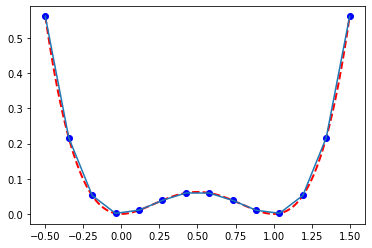

In [26]:
plt.plot(x, f(x), color='red', linestyle='--', linewidth=2)
plt.plot(q, yq, 'ro',color='blue')
plt.plot(x, B.dot(f(q)))

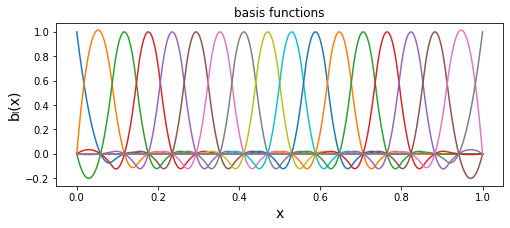

In [27]:

#Basis functions for ndofs = 20 and degree = 2
plt.figure(figsize = (8,3))
for i in range(18):
    _ = plt.plot( np.linspace(0,1,1025), basis_func(np.linspace(0,1,18),2)[i]( np.linspace(0,1,1025) ) )
    
_ = plt.xlabel("x", fontsize = 14)
_ = plt.ylabel("b\u2097(x)", fontsize = 14)
_ = plt.title("basis functions")

In [50]:

basis = basis_func( q, 5) # (1<=k<=5)
np.unique(basis[1].x)

array([-0.5       , -0.03846154,  0.11538462,  0.26923077,  0.42307692,
        0.57692308,  0.73076923,  0.88461538,  1.03846154,  1.5       ])

STEP 1.3

Write a function that, given a piecewise polynomial object of type PPoly and a number n_gauss_quadrature_points, computes the vector of global_quadrature_points and global_quadrature_weights, that contains replicas of a Gauss quadrature formula with n_gauss_quadrature_points on each of the intervals defined by unique(PPoly.x)

In [51]:
def global_quadr_weight( basis, n_gauss_quadrature_points):
    
    intervals = np.unique(basis[0].x)

    qp, w = np.polynomial.legendre.leggauss(n_gauss_quadrature_points)
    
    # for polynomials of degree 2*n_gauss_quadrature_points - 1 or less
    # rescale points, weights to work in the interval [0,1] rather than [-1,1]
    
    qp = (qp+1)/2
    w /= 2

    h = np.diff(intervals)
    global_quadrature = np.array([intervals[i]+h[i]*qp for i in range(len(h))]).reshape((-1,))
    global_weights = np.array([w*h[i] for i in range(len(h))]).reshape((-1,))
    
    return global_quadrature, global_weights

In [52]:
degree = 1
q = np.linspace(0, 1, 16) # M punti in [0,1]
basis = basis_func( q, degree)    
global_quadrature, global_weights = global_quadr_weight( basis, degree + 1)


STEP 1.4

Write a function that, given the basis and the quadrature points and weights, returns the two matrices $M$ and $K$

In [53]:
def system_matrices(basis, global_quadrature, global_weights):
    
    dbasis = [bi.derivative(1) for bi in basis]
    
    Bq = np.array([basis[i](global_quadrature) for i in range(len(basis))]).T
    dBq = np.array([dbasis[i](global_quadrature) for i in range(len(basis))]).T
    
    # return M, K
    return np.einsum('qi, q, qj', Bq, global_weights, Bq), np.einsum('qi, q, qj', dBq, global_weights, dBq)

# STEP2 

Solve the Allen-Cahan equation on the interval $[0,1]$, from time $t=0$ and time $t=1$, given a time step dt, a number of degrees of freedom ndofs, and a polynomial degree k.

STEP 2.1

Write a function that takes the initial value of $\eta_0$ as a function, eps, dt, ndofs, and degree, and returns a matrix of dimension (int(T/dt), ndofs) containing all the coefficients $\eta_k^i$ representing the solution, and the set of basis functions used to compute the solution

In [56]:

# Numerically solve Allen-Cahan
def solve_allen_cahan(eta_0_function, eps, dt, ndofs, degree):
    
    support_points = np.linspace(0,1,ndofs)
    
    basis = basis_func(support_points, degree)
    
    global_q, global_w=global_quadr_weight(basis, degree + 1)
    M, K = system_matrices(basis, global_q, global_w)
    
    T = 1.0  
    
    eta = np.zeros((int(T/dt) + 1, ndofs))
    
    A = M + eps*eps*dt*K
    
    eta_now = eta_0_function(support_points)
    
    eta[0,:] = eta_now
    
    for i in range(1, int(T/dt) + 1):
    
        b = M.dot(eta_now - dt * F(eta_now))
        eta_later = np.linalg.solve(A, b)
        eta[i,:] = eta_later
        eta_now = eta_later
                   
    return eta, basis

STEP 2.2

Write a function that takes all the solutions eta, the basis functions, a stride number s, and a resolution res, and plots on a single plot the solutions $\eta_0$, $\eta_s$, $\eta_{2s}$, computed on res equispaced points between zero and one

In [60]:
def plot_solution(eta, basis, stride, res, legend = False, title = ""):

    x = np.linspace(0,1,res)
    B = np.zeros((res, len(basis)))
    
    for i in range(len(basis)):
        B[:,i] = basis[i](x)
        
    eta_plot = eta[::stride].dot(B.T)
    
    T = 1.0  
    
    for i in range(eta_plot.shape[0]):
        plt.plot(x, eta_plot[i,:], label = "t = " + str(i*stride*T/(eta.shape[0]-1)))
        
    plt.xlabel("x", fontsize = 14)
    plt.ylabel("\u03B7\u209C(x)", fontsize = 14)
    plt.title("solution \u03B7\u209C(x)" + title)
    
    if (legend == True):
        plt.legend()

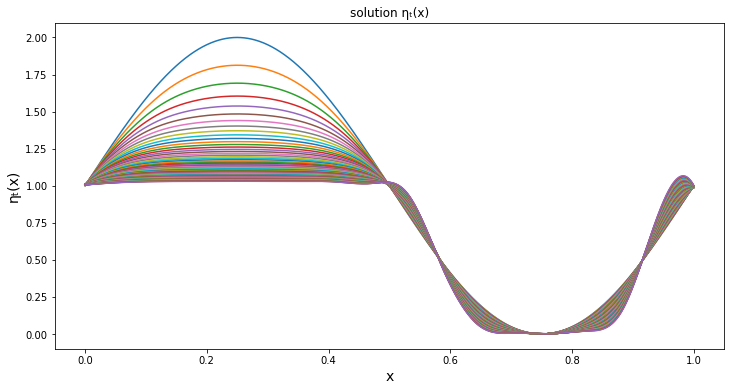

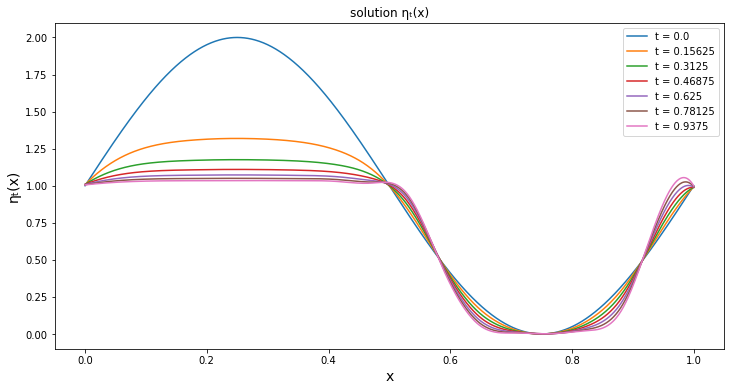

In [61]:
def eta_0_function(x):
    return np.sin(2.*np.pi*x) + 1.

eps = 0.01
dt = 0.015625
ndofs = 18
degree = 3

eta, basis = solve_allen_cahan(eta_0_function, eps, dt, ndofs, degree)

stride = 1
res = 1025

plt.figure(figsize = (12,6))
plot_solution(eta, basis, stride, res)

stride = 10

plt.figure(figsize = (12,6))
plot_solution(eta, basis, stride, res, legend = True)

# STEP 3

Solve the problem for all combinations of

    1. eps = [01, .001]

    2. ndofs = [16, 32, 64, 128]

    3. degree = [1, 2, 3]

    4. dt = [.25, .125, .0625, .03125, .015625]

with $\eta_0 = \sin(2 \pi x)+1$.

Plot the final solution at $t=1$ in all cases. What do you observe? What happens when you increase ndofs and keep dt constant?

In [62]:
def plot_solution_final(eta, basis, res, initial = False, title = ""):
    # plot eta[-1,:], on x = linspace(0,1,resolution)
    x = np.linspace(0,1,res)
    B = np.zeros((res, len(basis)))  #
    
    for i in range(len(basis)):
        B[:,i] = basis[i](x)
        
    plt.plot(x, eta[-1,:].dot(B.T), label = "t = 1", color='blue', linestyle='--', linewidth=3)
        
    if (initial == True):
        plt.plot(x, eta[0,:].dot(B.T), label = "t = 0", color='red')    
        
    plt.legend()
    plt.xlabel("x", fontsize = 14)
    plt.ylabel("\u03B7 \u209C (x)", fontsize = 14)
    plt.title("solution \u03B7 \u209C (x)" + title)

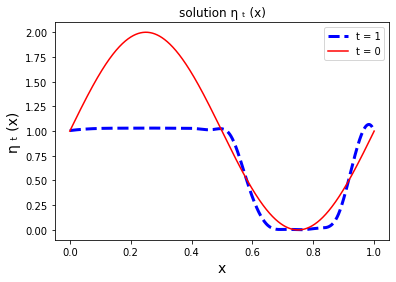

In [63]:

plot_solution_final(eta, basis, res,True)

In [17]:

def solutions(eps, degree, res, initial = False):
    dt = [.25, .125, .0625, .03125, .015625]
    ndofs = [16, 32, 64, 128]
    
    print("\033[1m SOLUTION AT eps = " + str(eps) + ", degree = " + str(degree) + " \033[0m \n")

    plt.figure(figsize = (20,18))

    for i in range(len(dt)):
        for j in range(len(ndofs)):
            
            eta, basis = solve_allen_cahan(eta_0_function, eps, dt[i], ndofs[j], degree)
            
            plt.subplot(len(dt), len(ndofs), int(len(ndofs)*i + j + 1))
            plot_solution_final(eta, basis, resolution, initial = initial, title = " at dt = " + str(dt[i]) + ", ndofs = " + str(ndofs[j]))
        
    plt.tight_layout()

 SOLUTION AT eps = 0.01, degree = 1  



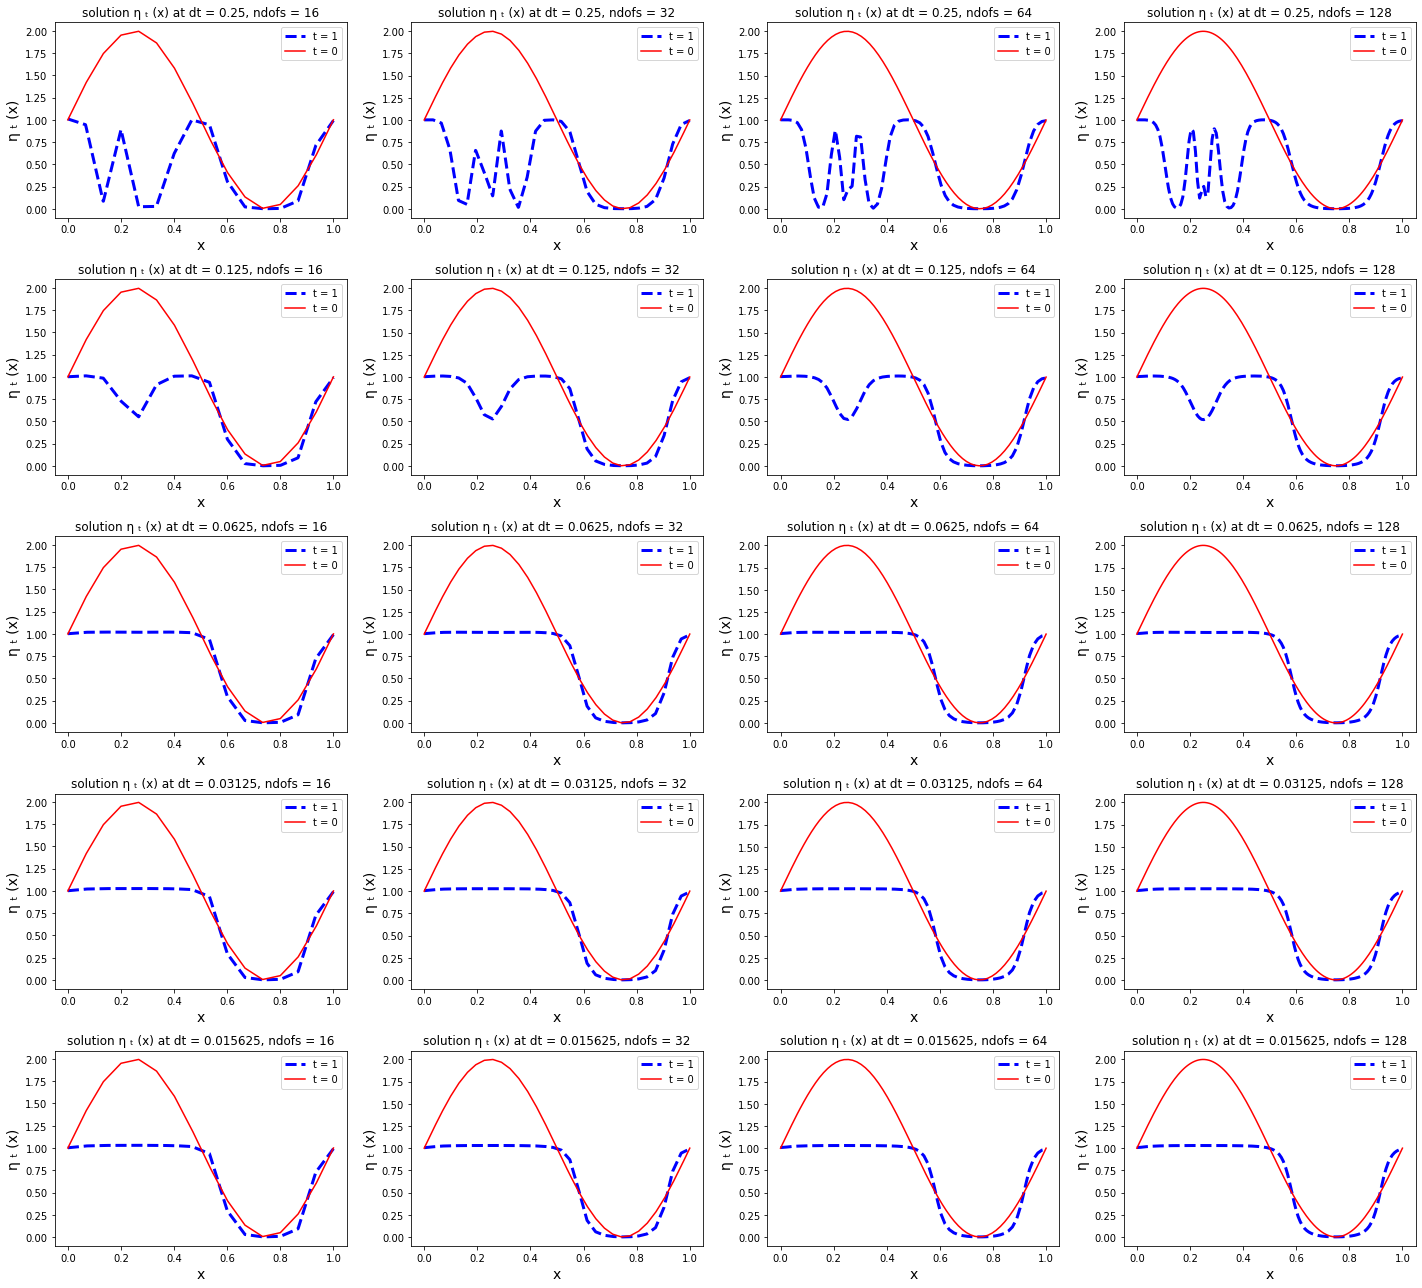

In [64]:

eps = 0.01
degree = 1
resolution = 1025
solutions(eps, degree, resolution, initial = True)

 SOLUTION AT eps = 0.001, degree = 1  



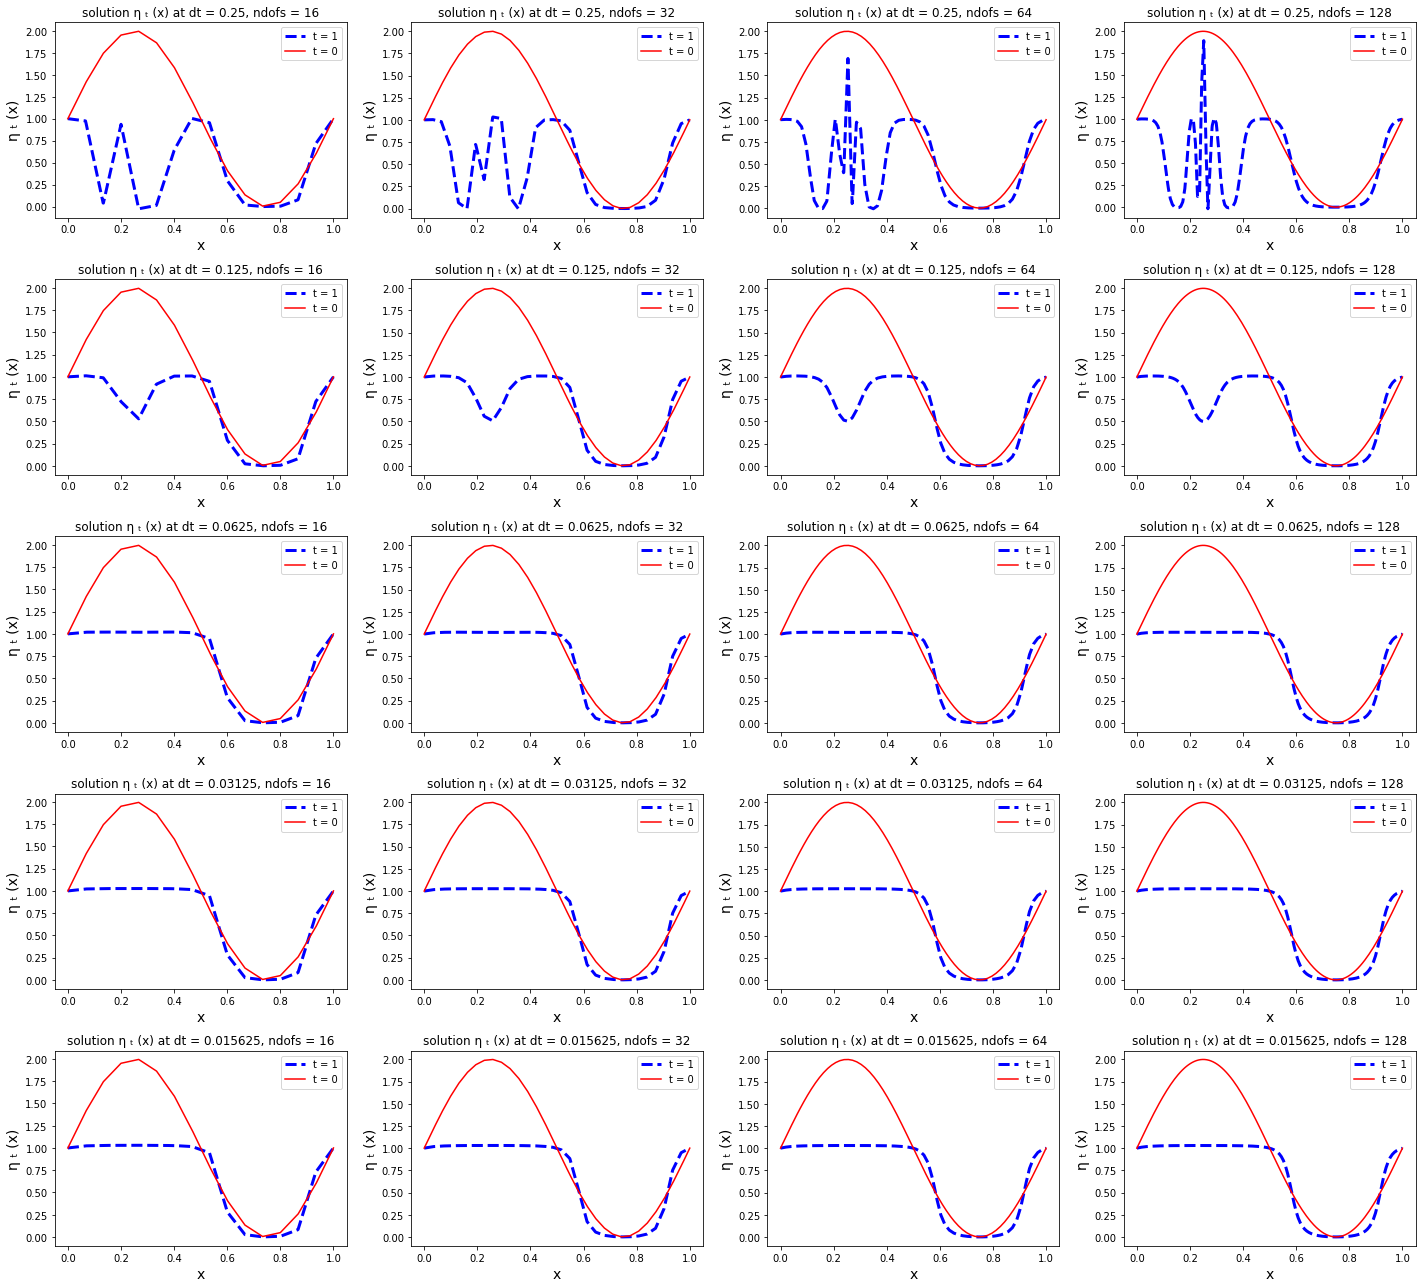

In [27]:
eps = 0.001
degree = 1
resolution = 1025
solutions(eps, degree, resolution, initial = True)

 SOLUTION AT eps = 0.01, degree = 2  



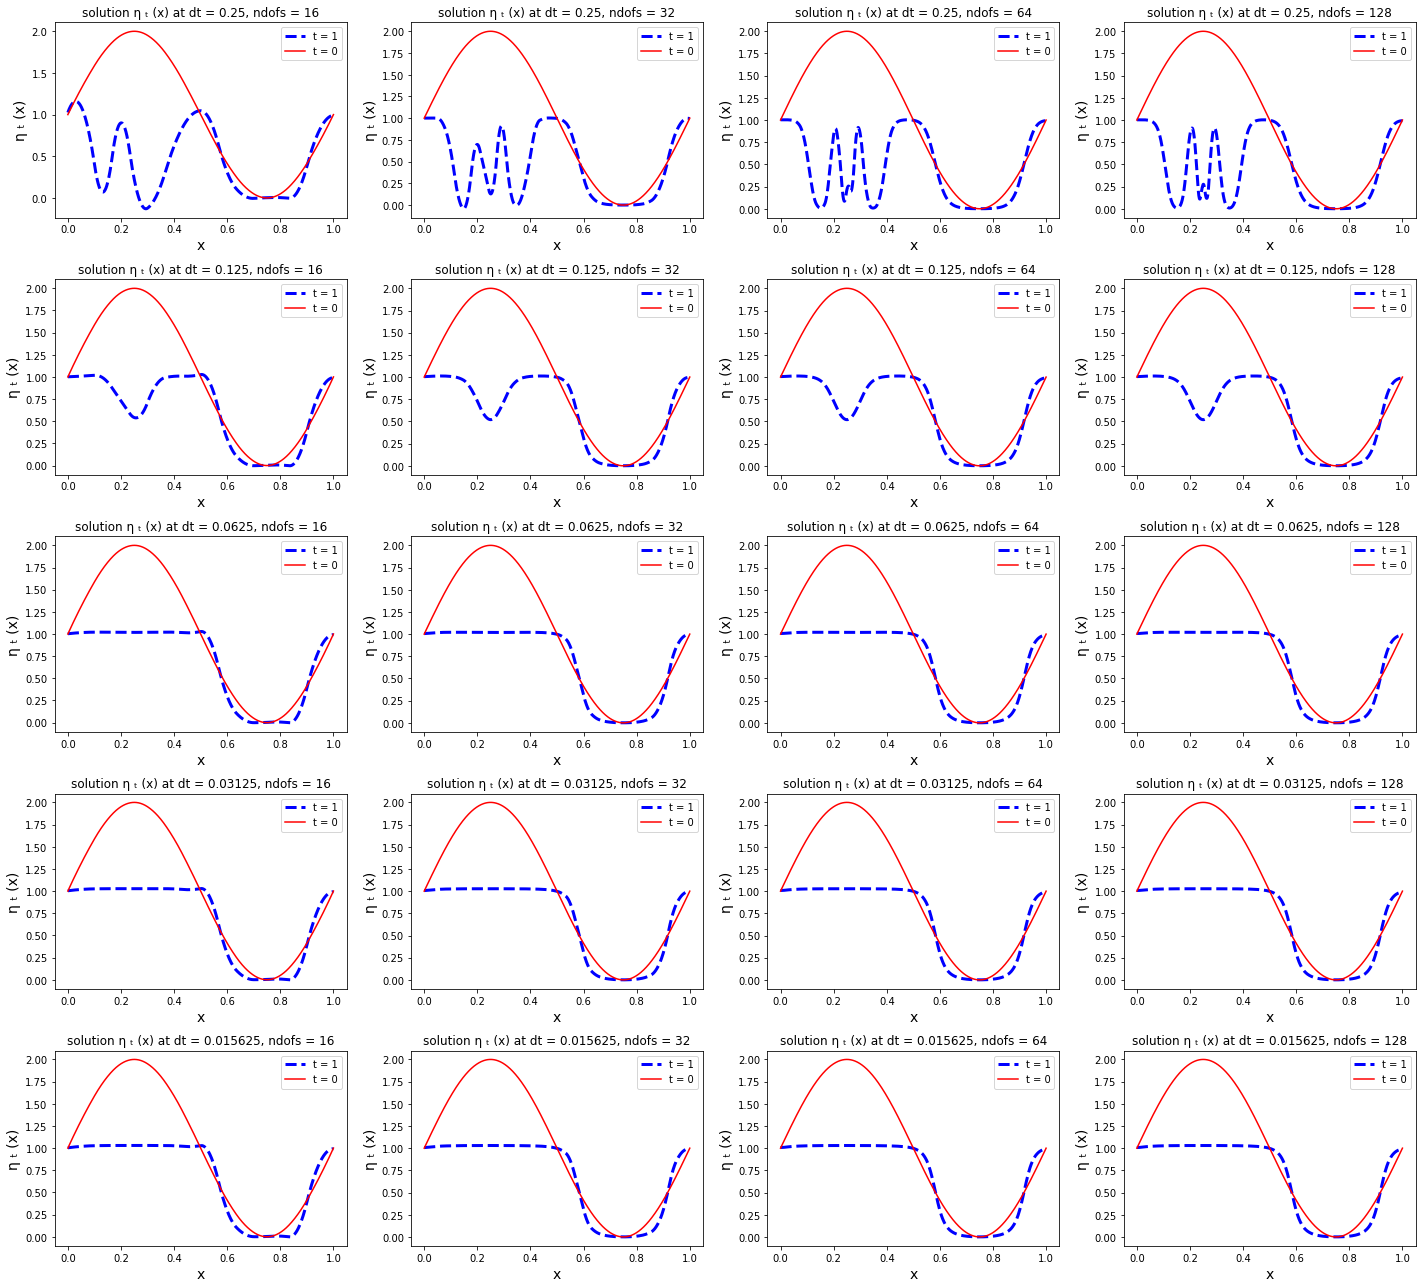

In [28]:

eps = 0.01
degree = 2
resolution = 1025

solutions(eps, degree, resolution, initial = True)

 SOLUTION AT eps = 0.001, degree = 2  



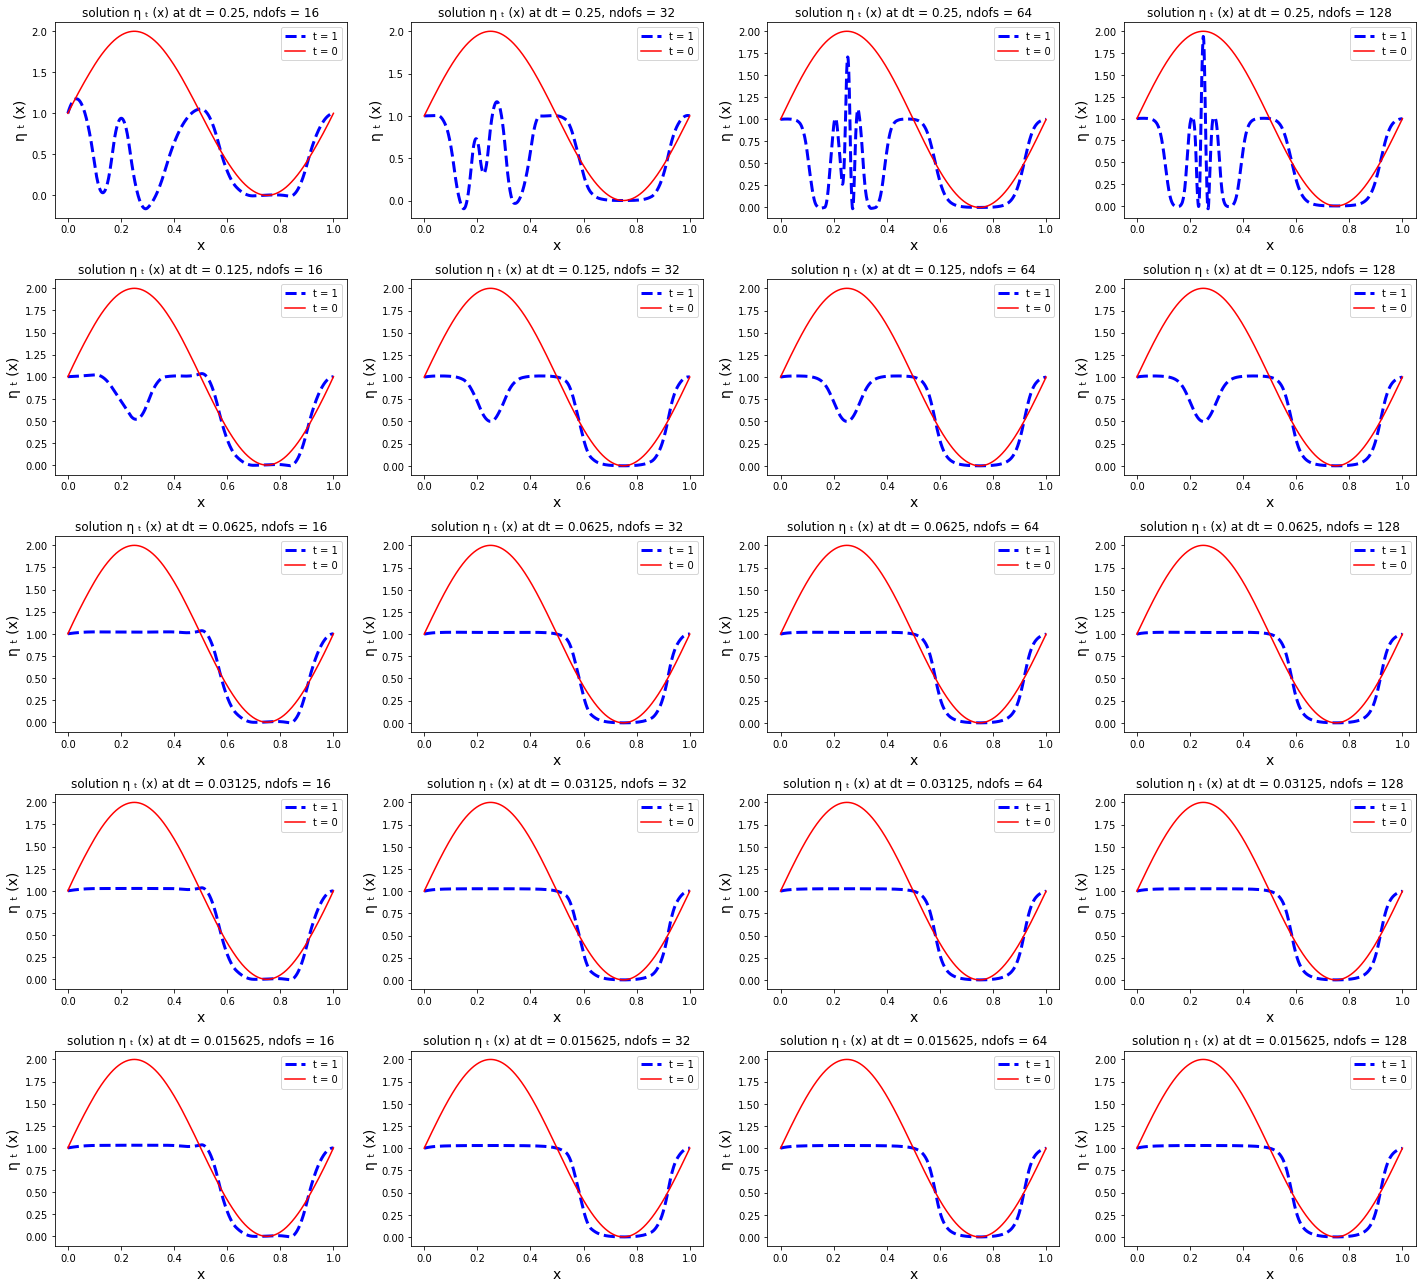

In [29]:
eps = 0.001
degree = 2
resolution = 1025

solutions(eps, degree, resolution, initial = True)

 SOLUTION AT eps = 0.01, degree = 3  



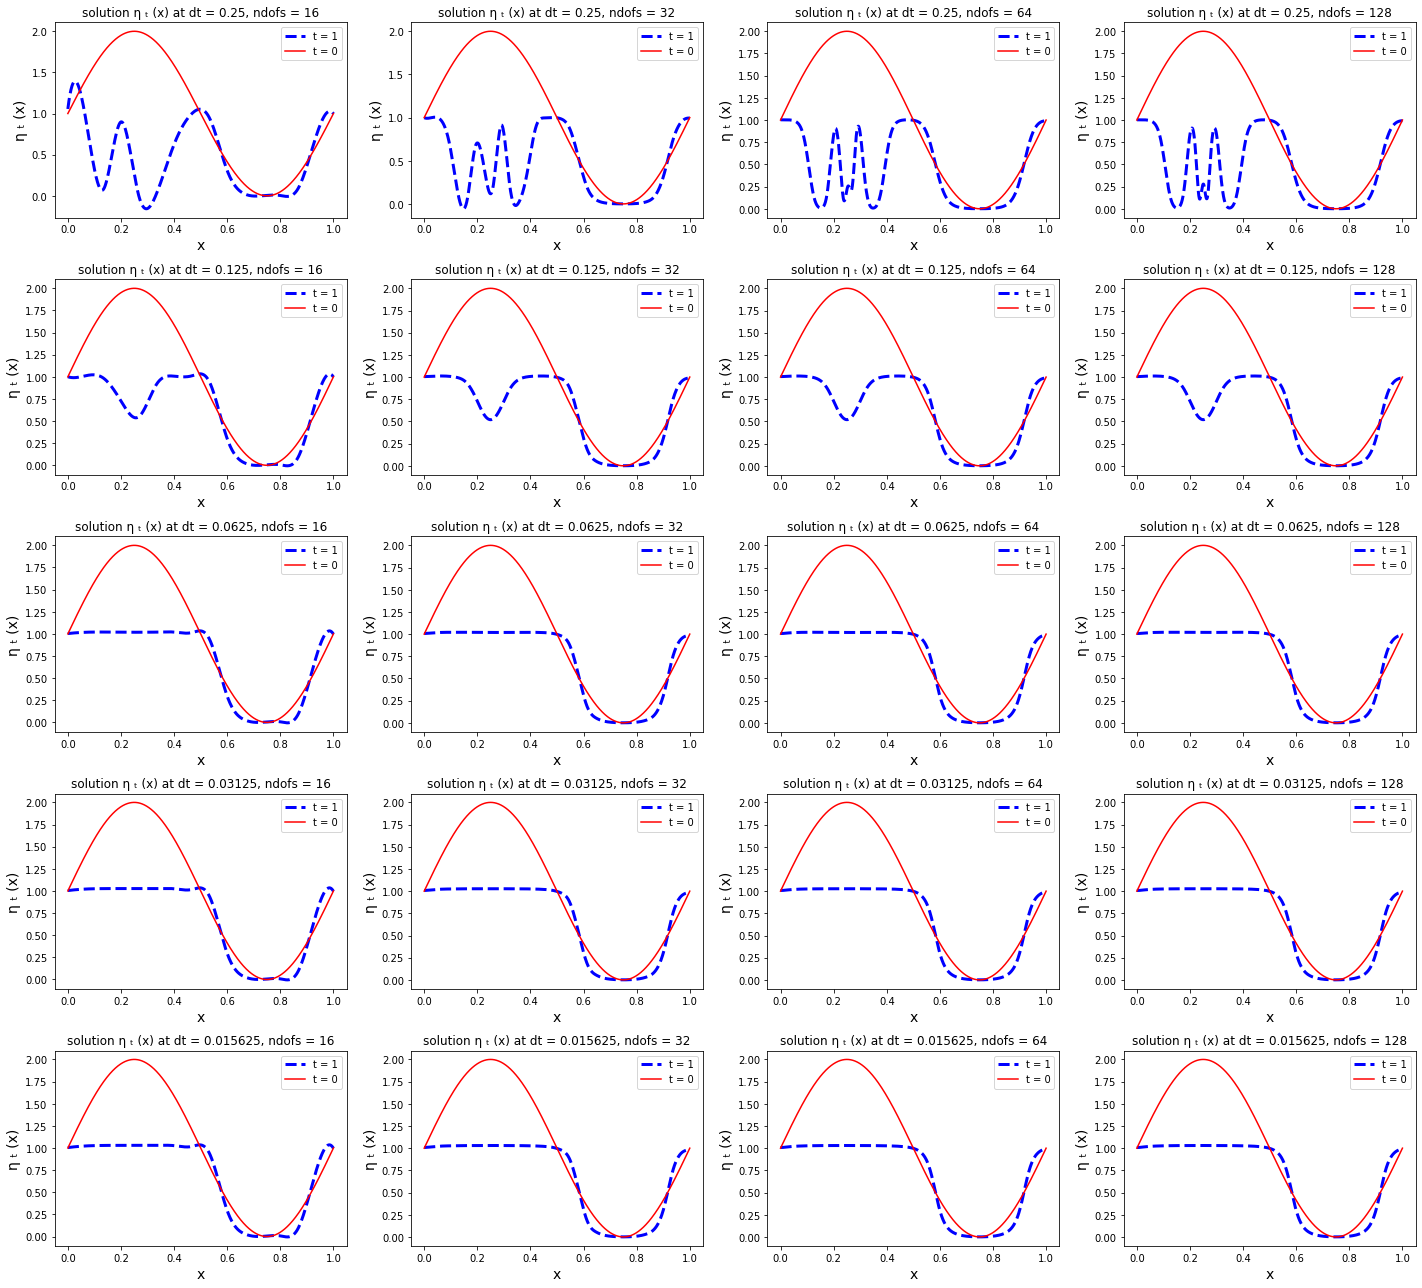

In [30]:
eps = 0.01
degree = 3
resolution = 1025

solutions(eps, degree, resolution, initial = True)

 SOLUTION AT eps = 0.001, degree = 3  



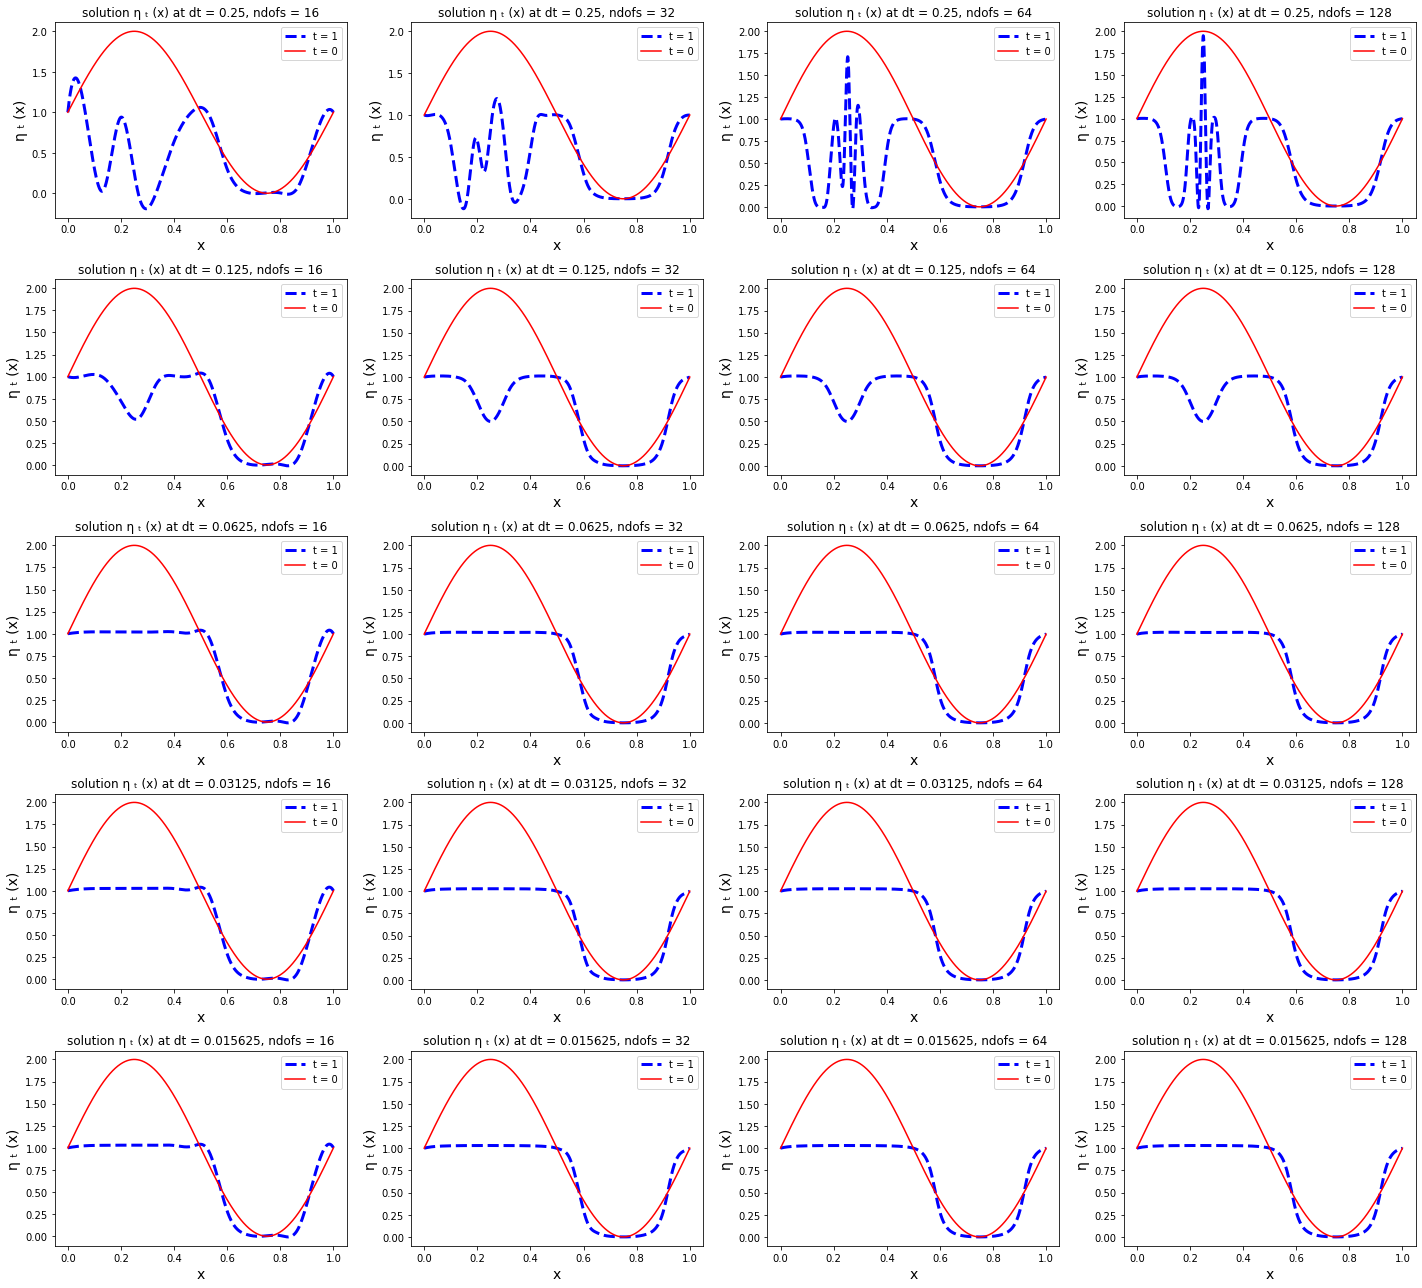

In [31]:

eps = 0.001
degree = 3
resolution = 1025

solutions(eps, degree, resolution, initial = True)


The numerical solution (at least for small $\Delta t$) correctly tends to the expected solution given our potential: $1$ for $\eta &gt; 0.5$, $0$ for $\eta &lt; 0.5$.

If we increase the number of degrees of freedom while keeping $\Delta t$ constant, the final solution gets smoother.

The solution gets smoother also when increasing the degree of th epolynomial basis.

For large $\Delta t$ the solution does not always converge: this is because the forward Euler method is not stable for all range of parameters and also because time derivative approximations become less precise for large $\Delta t$.

# STEP 4